<a href="https://colab.research.google.com/github/NikithaBangera/COMP6721_Artificial_Intelligence/blob/main/Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mounting the drive containing the datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing the required libraries


In [ ]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder, DatasetFolder
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from torchvision.transforms import ToTensor
import pandas as pd

# Training Dataset Creation

Loading the dataset from the directory

In [ ]:
def load_dataset(directory_path):
  image_transforms = transforms.Compose(
                    [transforms.Resize((32,32)),
                     transforms.ToTensor(),
                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])
  
  dataset = ImageFolder(
                        root = directory_path,
                        transform = image_transforms
                        )
  return dataset

directory_path = "/content/drive/My Drive/AI Dataset/data/"
dataset = load_dataset(directory_path)

Dataset classes/labels

In [ ]:
classes = dataset.classes
classes

['not_a_person', 'with_mask', 'without_mask']

Counting the number of images present in each of the classes

In [ ]:
 def data_class_distribution(dataset):
  data_class_count = {}
  for _, index in dataset:
    label = classes[index]
    if label not in data_class_count:
      data_class_count[label] = 0
    data_class_count[label] += 1
  return data_class_count
    
 data_class_count = data_class_distribution(dataset)
 print("The number of images present in each of the three classes:", data_class_count)

KeyboardInterrupt: ignored

# Dataset Visualization

In [ ]:
def plot_dataset_images(file_path, images_list):
  rows=20 #rows in subplots
  cols=5 #columns in subplots

  fig,ax = plt.subplots(rows,cols,figsize=(12,100))
  r = 0
  c = 0
  for i in range(rows*cols):
    aa = plt.imread(os.path.join(file_path, images_list[i]))
    ax[r,c].axis("off")
    ax[r,c].imshow(aa)
      c+=1
      if c == cols:
        c=0
        r+=1
  plt.show()

1. Sample images of the class "With a mask"

In [ ]:
with_mask_file_path = "/content/drive/My Drive/AI Dataset/data/with_mask"
with_mask_images = os.listdir("/content/drive/My Drive/AI Dataset/data/with_mask")

plot_dataset_images(with_mask_file_path, with_mask_images)

2. Sample images of the class "Without a mask"

In [ ]:
without_mask_file_path = "/content/drive/My Drive/AI Dataset/data/without_mask"
without_mask_images = os.listdir("/content/drive/My Drive/AI Dataset/data/without_mask")

plot_dataset_images(without_mask_file_path, without_mask_images)

3. Sample images of the class "Not a person"

In [ ]:
not_a_person_file_path = "/content/drive/My Drive/AI Dataset/data/not_a_person"
not_a_person_images = os.listdir("/content/drive/My Drive/AI Dataset/data/not_a_person")

plot_dataset_images(not_a_person_file_path, not_a_person_images)

Categorical representation of the datasets

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


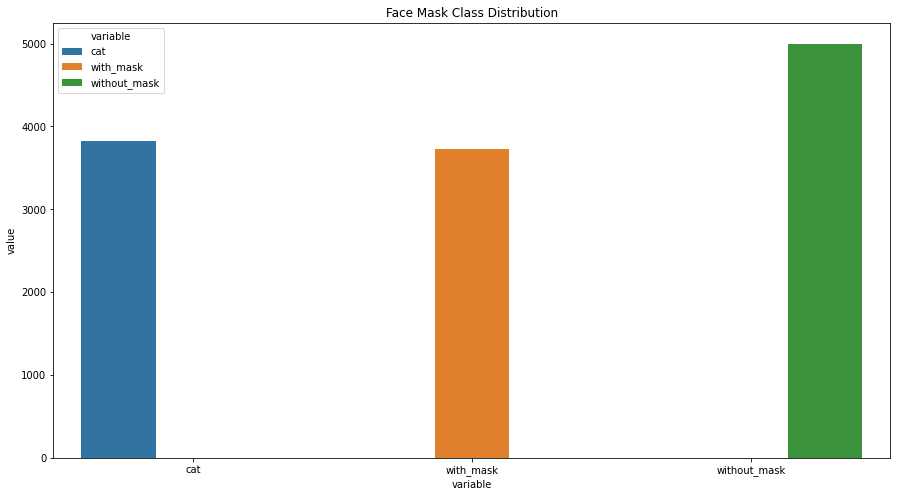

In [ ]:
plt.figure(figsize=(15,8))
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(dataset)]).melt(), x = "variable", y="value", hue="variable").set_title('Face Mask Class Distribution')
plt.show()

Splitting the Data into train, validation and test sets

In [ ]:
train_size = int(0.8 * len(dataset))
test_size = (len(dataset) - train_size) * 0.5
train_dataset, val_dataset, test_dataset = random_split(dataset, (train_size, test_size, test_size))

# Loading Data with the help of DataLoader

In [ ]:
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=4, num_workers=2)
val_loader = DataLoader(dataset=val_dataset, shuffle=False, batch_size=4, num_workers=2)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=4, num_workers=2)
print("Length of the train_loader:", len(train_loader))
print("Length of the val_loader:", len(val_loader))
print("Length of the val_loader:", len(test_loader))

Length of the train_loader: 3601
Length of the val_loader: 901


# Convolutional Neural Network Architecture and model training

CNN Model Architecture

In [ ]:
class CNN(nn.Module):

  def __init__(self):
    super(CNN, self).__init__()
    self.conv_layer = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.fully_connected_layer = nn.Sequential(
        nn.Dropout(p=0.1),
        nn.Linear(8 * 8 * 32, 1000),
        nn.ReLU(inplace=True),
        nn.Linear(1000, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.1),
        nn.Linear(512, 128),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.1),
        nn.Linear(128, 3)
    )

  def forward(self, x):
    #convolutional layers
    x = self.conv_layer(x)

    #flattening the layers
    x = x.view(x.size(0), -1)

    #fully connected layer
    x = self.fully_connected_layer(x)

    return x

CNN model, loss function and Optimizer initialization


In [ ]:
net = CNN()
criterion = nn.CrossEntropyLoss()
#using Stochastic Gradient Descent
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 

Training the CNN model

In [ ]:
def images_to_probs(net, images):
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def evaluate(net, dataloader):
    correct, total = 0, 0
    with torch.no_grad():
        net.eval()
        for images, labels in dataloader:
            images, labels = images, labels.numpy()

            preds, probs = images_to_probs(net, images)

            total += len(labels)
            correct += (preds == labels).sum()
    return correct/total * 100

from tqdm.notebook import tqdm

def train(net, loss_fn, opt, dataloader, epochs):
    num_steps = 0
    min_loss = 1e+10

    for epoch in tqdm(range(1, epochs+1), total=epochs, desc='Training'):
        running_loss = []
        net.train() # Setting the network to TRAIN mode
        for images, labels in dataloader:
            images, labels = images, labels
            num_steps += 1

            # FP
            outs = net(images)
            loss = loss_fn(outs, labels)

            # Logging the loss value
            running_loss.append(loss.item())

            # BP
            opt.zero_grad()
            loss.backward()
            opt.step()

            # Clearing the RAM
            #del images, labels, outs
            #torch.device('cpu').empty_cache()
        
        epoch_loss = sum(running_loss) / len(running_loss)
        acc = evaluate(net, dataloader)
        print("Accuracy: ",acc)
        print("loss: ",epoch_loss)
        # Model Checkpointing
        if epoch_loss < min_loss:
            min_loss = epoch_loss
            bestmodel = net.state_dict()
    #torch.save(bestmodel,'{0}_{1:0.4f}.pth'.format('classifier',min_loss))
    return None

    print('Training finished!!!')

In [ ]:
num_epochs = 10
train(net, criterion, optimizer, train_loader, num_epochs)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/Ti

Accuracy:  90.56512079977784
loss:  0.4546296715434957


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes sh

Accuracy:  95.2374340460983
loss:  0.2330034772198422


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(

Accuracy:  96.58428214384894
loss:  0.16041571948974578


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Accuracy:  96.67453485143017
loss:  0.11400051359874333


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Accuracy:  98.81282976950847
loss:  0.07863925507610567


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparen

Accuracy:  98.60455429047487
loss:  0.06158120785588171


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Ti

Accuracy:  99.18772563176896
loss:  0.050516159285522784


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(

Accuracy:  98.88225492918635
loss:  0.04061173087584998


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparen

Accuracy:  99.48625381838379
loss:  0.03070037082696034


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Im

Accuracy:  99.65287420161066
loss:  0.025951003238280534



# Testing Network

In [ ]:
testimg, testlab = next(iter(val_loader))
testimg, testlab = testimg, testlab

pred = net(testimg)
predlab = torch.argmax(pred,axis=1)

# Prediction 


In [ ]:
print("Predicted",[i for i in predlab])
print("Actual",[i for i in testlab])
for i in predlab:
  if i == 0:
    print("without_mask")
  elif i ==1:
    print("with_mask")
  else :
    print("not_a_person")
print("______________________________________________________________________________________________________________")
for i in testlab:
  if i == 0:
    print("without_mask")
  elif i ==1:
    print("with_mask")
  else :
    print("not_a_person")

Predicted [tensor(0), tensor(2), tensor(1), tensor(0)]
Actual [tensor(0), tensor(2), tensor(1), tensor(0)]
without_mask
not_a_person
with_mask
without_mask
______________________________________________________________________________________________________________
without_mask
not_a_person
with_mask
without_mask


# Confusion Matrix

In [ ]:
predlab = predlab.to(torch.device('cpu'))
testlab = testlab.to(torch.device('cpu'))
pred = predlab.numpy()
test = testlab.numpy()
matrix = confusion_matrix(test,pred)
print(matrix)

[[2 0 0]
 [0 1 0]
 [0 0 1]]


# Classification Report

In [ ]:
report = classification_report(test, pred, target_names=['with_mask','without_mask','not_a_person'])
print(report)  

              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00         2
without_mask       1.00      1.00      1.00         1
not_a_person       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



# Convolutional Neural Network Architecture and model training

In [ ]:
#requires modifications as per the image pixel and the number of labels
class CNN(nn.Module):

  def __init__(self):
    super(CNN, self).__init__()
    self.conv_layer = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.fc_layer = nn.Sequential(
        nn.Dropout(p=0.1),
        nn.Linear(8 * 8 * 32, 1000),
        nn.ReLU(inplace=True),
        nn.Linear(1000, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.1),
        nn.Linear(512, 128),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.1),
        nn.Linear(128, 3)
    )

  def forward(self, x):
    #convoltional layers
    x = self.conv_layer(x)

    #flatten the layers
    x = x.view(x.size(0), -1)

    #fc layer
    x = self.fc_layer(x)

    return x

Hyper-paramaters definition

In [ ]:
num_epochs = 10
num_classes = 3
learning_rate = 0.001

# Convolutional Neural Network Model Evaluation